# Chapter 7: Ensemble Learning and Random Forests

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
import warnings
warnings.filterwarnings('ignore')

If we aggregate the predictions of a group of predictors (such as classifiers and regressors), we will often get bettern predictions than with the best individual predictor. A group of predictors is called an ensemble; thus this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method. Such an ensemble of Decision Trees is called a Random Forest,
and despite its simplicity, this is one of the most powerful Machine Learning algorithms
available today.

In this chapter we will discuss bagging, boosting, stacking and others.

---

# Voting Classifiers

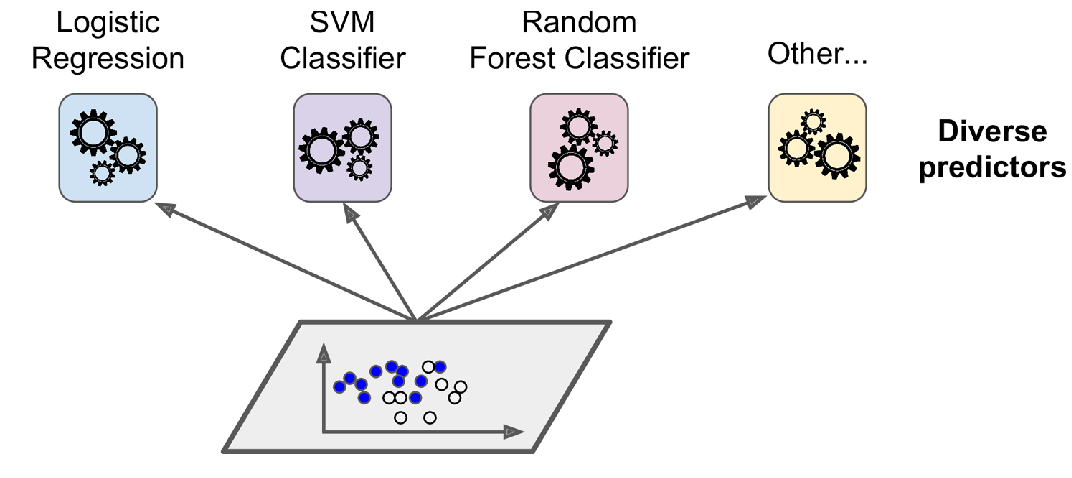

In [14]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict1.png'))
plt.grid(False)
plt.axis('off');

A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier
is called a hard voting classifier

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning
it does only slightly better than random guessing), the ensemble can still be a
strong learner (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery.
Suppose you have a slightly biased coin that has a 51% chance of coming up heads,
and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. If you do the
math, you will find that the probability of obtaining a majority of heads after 1,000
tosses is close to 75%. The more you toss the coin, the higher the probability (e.g.,
with 10,000 tosses, the probability climbs over 97%). This is due to the law of large
numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the
probability of heads (51%).

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually
correct only 51% of the time (barely better than random guessing). If you predict
the majority voted class, you can hope for up to 75% accuracy! However, this is
only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case since they are trained on the same data. They are likely to
make the same types of errors, so there will be many majority votes for the wrong
class, reducing the ensemble’s accuracy.

Ensemble methods work best when the predictors are as independent
from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [19]:
X, y = make_moons(n_samples=10000, noise=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [24]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [26]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8252
RandomForestClassifier 0.8312
SVC 0.8664
VotingClassifier 0.856


If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft
voting. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities. This is
not the case of the SVC class by default, so you need to set its probability hyperparameter
to True (this will make the SVC class use cross-validation to estimate class probabilities,
slowing down training, and it will add a predict_proba() method). If you
modify the preceding code to use soft voting, you will find that the voting classifier
achieves over 91% accuracy!

---

# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed. Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed with replacement, this method is called bagging (short for
bootstrap aggregating). When sampling is performed without replacement, it is called
pasting.

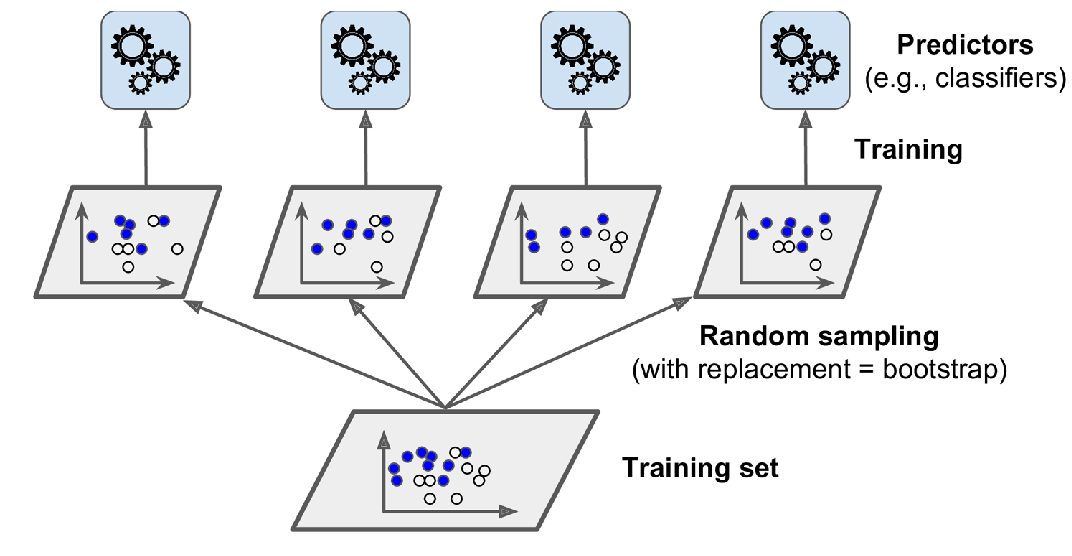

In [27]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict2.png'))
plt.grid(False)
plt.axis('off');

In [29]:
list(zip([1, 2, 3], [1, 2, 3, 4, 5]))

[(1, 1), (2, 2), (3, 3)]

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression. Each individual
predictor has a higher bias than if it were trained on the original training set, but
aggregation reduces both bias and variance. Generally, the net result is that theGenerally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the
original training set.

## Bagging and Pasting in scikit-learn

Classification: BaggingClassifier and Regression: BaggingRegressor

The following code trains an
ensemble of 500 Decision Tree classifiers,5 each trained on 100 training instances randomly
sampled from the training set with replacement (this is an example of bagging,
but if you want to use pasting instead, just set bootstrap=False). The n_jobs parameter
tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores):

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100,
                           bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
print("Accuracy score: {}".format(accuracy_score(y_test, bag_clf.predict(X_test))))

Accuracy score: 0.8612


The BaggingClassifier automatically performs soft voting
instead of hard voting if the base classifier can estimate class probabilities
(i.e., if it has a predict_proba() method), which is the case
with Decision Trees classifiers.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting, but this also
means that predictors end up being less correlated so the ensemble’s variance is
reduced. Overall, bagging often results in better models, which explains why it is generally
preferred. However, if you have spare time and CPU power you can use crossvalidation
to evaluate both bagging and pasting and select the one that works best.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor.6 The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set or cross-validation. You
can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In [33]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100,
                           bootstrap=True, n_jobs=-1, oob_score=True)

In [34]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [35]:
bag_clf.oob_score_

0.8653333333333333

In [36]:
accuracy_score(y_test, bag_clf.predict(X_test))

0.864

---

# Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This is controlled
by two hyperparameters: max_features and bootstrap_features. They work
the same way as max_samples and bootstrap, but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the
input features.

This is particularly useful when you are dealing with high-dimensional inputs (such
as images). Sampling both training instances and features is called the Random
Patches method.

Keeping all training instances (i.e., bootstrap=False and max_sam
ples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_features smaller than 1.0) is called the Random Subspaces method.

---

# Random Forests

Instead of building a BaggingClassifier and passing
it a DecisionTreeClassifier, you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees10 (similarly, there is
a RandomForestRegressor class for regression tasks). The following code trains a
Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using
all available CPU cores:

In [38]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
print("Accuracy score: {}".format(accuracy_score(y_test, rnd_clf.predict(X_test))))

Accuracy score: 0.856


With a few exceptions, a RandomForestClassifier has all the hyperparameters of a
DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters
of a BaggingClassifier to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node, it
searches for the best feature among a random subset of features. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance,
generally yielding an overall better model. The following BaggingClassifier is
roughly equivalent to the previous RandomForestClassifier:

In [39]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

## Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset
of the features is considered for splitting (as discussed earlier). It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).


A forest of such extremely random trees is simply called an Extremely Randomized
Trees ensemble12 (or Extra-Trees for short). Once again, this trades more bias for a
lower variance. It also makes Extra-Trees much faster to train than regular Random
Forests since finding the best possible threshold for each feature at every node is one
of the most time-consuming tasks of growing a tree.


You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier
class. Its API is identical to the RandomForestClassifier class. Similarly, the Extra
TreesRegressor class has the same API as the RandomForestRegressor class.

## Feature Importance

In [40]:
from sklearn.datasets import load_iris
iris = load_iris()

In [41]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09892831481521595
sepal width (cm) 0.02294424657347966
petal length (cm) 0.4616274560172856
petal width (cm) 0.41649998259401844


Feature importances using MNIST dataset:

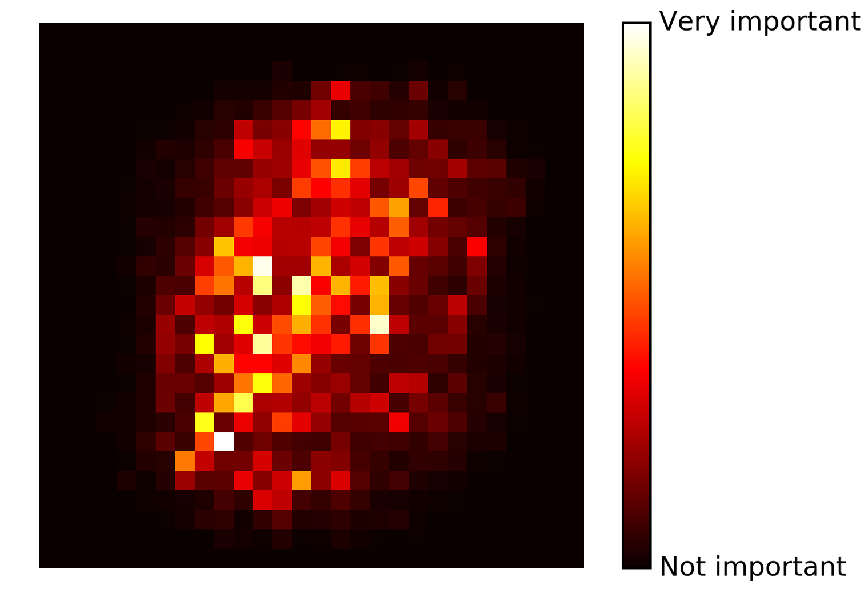

In [42]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict3.png'))
plt.grid(False)
plt.axis('off');

---

# Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its predecessor.
There are many boosting methods available, but by far the most popular are
AdaBoost (short for Adaptive Boosting) and Gradient Boosting.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by Ada‐
Boost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision
Tree) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on

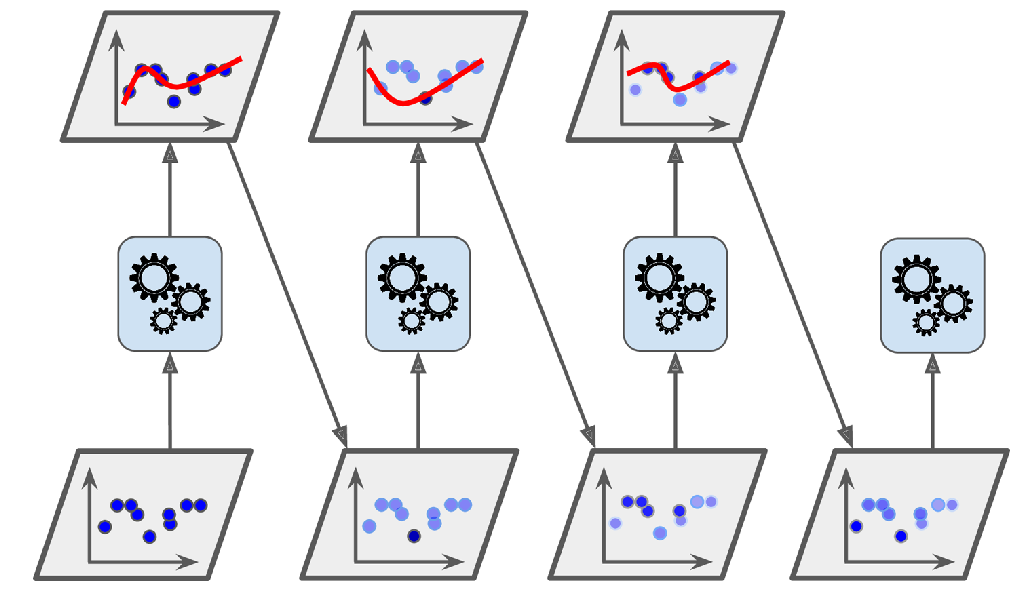

In [43]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict4.png'))
plt.grid(False)
plt.axis('off');

As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s. Once all predictors are trained, the ensemble makes predictions very much like bagging
or pasting, except that predictors have different weights depending on their
overall accuracy on the weighted training set. There is one important drawback to this sequential learning technique:
it cannot be parallelized (or only partially), since each predictor
can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bagging
or pasting.

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME (which
stands for Stagewise Additive Modeling using a Multiclass Exponential loss function).
When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the
predictors can estimate class probabilities (i.e., if they have a predict_proba()
method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands
for “Real”), which relies on class probabilities rather than predictions and generally
performs better.

The following code trains an AdaBoost classifier based on 200 Decision Stumps using
Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada
BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1—in
other words, a tree composed of a single decision node plus two leaf nodes. This is
the default base estimator for the AdaBoostClassifier class:

In [44]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                             algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

If your AdaBoost ensemble is overfitting the training set, you can
try reducing the number of estimators or more strongly regularizing
the base estimator.

## Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting. Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

Let’s go through a simple regression example using Decision Trees as the base predictors
(of course Gradient Boosting also works great with regression tasks). This is
called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s
fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training
set):

In [79]:
X = np.random.uniform(-1, 1, size=(150))
y = X**2 + np.random.normal(size=150, scale=0.5) * 0.25
X = X.reshape(-1, 1)
y = y.ravel()

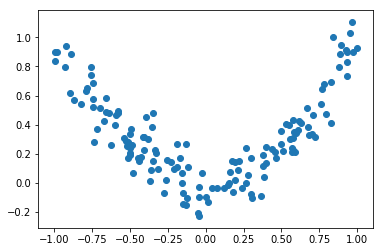

In [72]:
plt.scatter(X, y)

In [80]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Now train a second DecisionTreeRegressor on the residual errors made by the first
predictor:

In [81]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2).fit(X, y2)

In [82]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2).fit(X, y3)

In [84]:
y_pred = sum(tree.predict(np.random.uniform(-1, 1, size=(150)).reshape(-1, 1)) for tree in (tree_reg1, tree_reg2, tree_reg3))

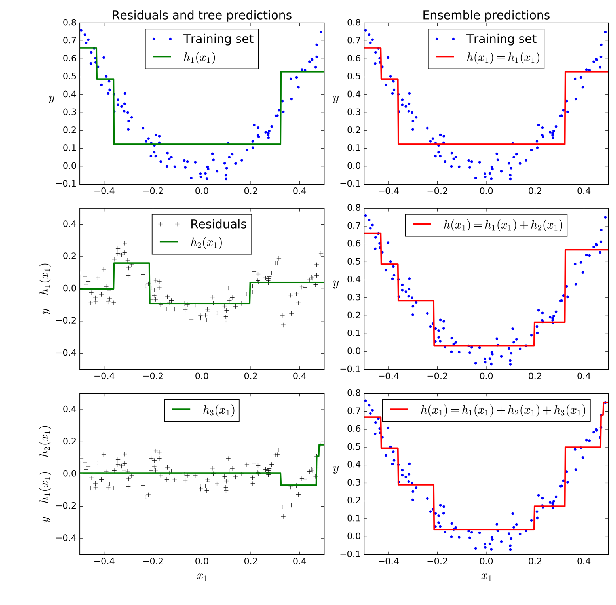

In [85]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict5.png'))
plt.grid(False)
plt.axis('off');

Figure above represents the predictions of these three trees in the left column, and the
ensemble’s predictions in the right column. In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can
see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of
the second tree. You can see that the ensemble’s predictions gradually get better as
trees are added to the ensemble.

A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRe
gressor class. Much like the RandomForestRegressor class, it has hyperparameters to
control the growth of Decision Trees (e.g., max_depth, min_samples_leaf, and so on),
as well as hyperparameters to control the ensemble training, such as the number of
trees (n_estimators). The following code creates the same ensemble as the previous
one:

In [86]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the training
set, but the predictions will usually generalize better. This is a regularization technique
called shrinkage. Figure shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

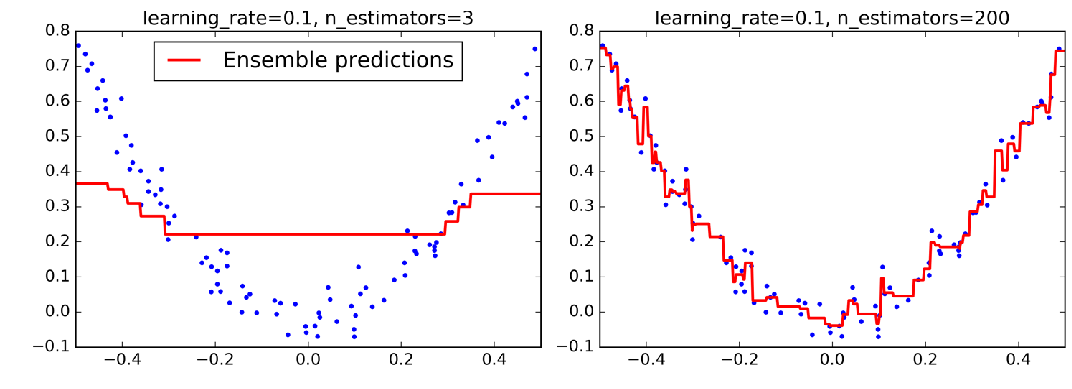

In [87]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict6.png'))
plt.grid(False)
plt.axis('off');

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the staged_predict() method: it
returns an iterator over the predictions made by the ensemble at each stage of training
(with one tree, two trees, etc.). The following code trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the optimal
number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:

In [88]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]

best_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=75, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True, which makes Scikit-
Learn keep existing trees when the fit() method is called, allowing incremental
training. The following code stops training when the validation error does not
improve for five iterations in a row:

In [91]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

---

# Stacking

The last Ensemble method we will discuss in this chapter is called stacking (short for
stacked generalization). It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
why don’t we train a model to perform this aggregation? Figure shows such an
ensemble performing a regression task on a new instance. Each of the bottom three
predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
(called a blender, or a meta learner) takes these predictions as inputs and makes the
final prediction (3.0).

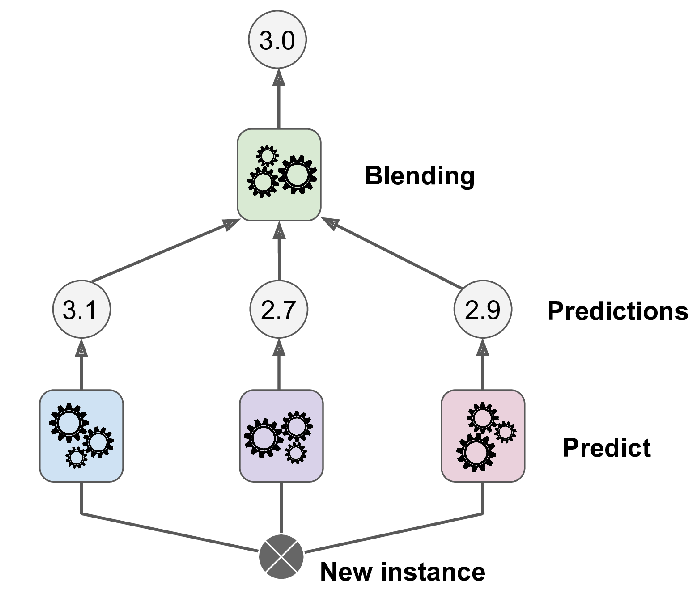

In [92]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict7.png'))
plt.grid(False)
plt.axis('off');

To train the blender, a common approach is to use a hold-out set. Let’s see how it
works. First, the training set is split in two subsets. The first subset is used to train the
predictors in the first layer

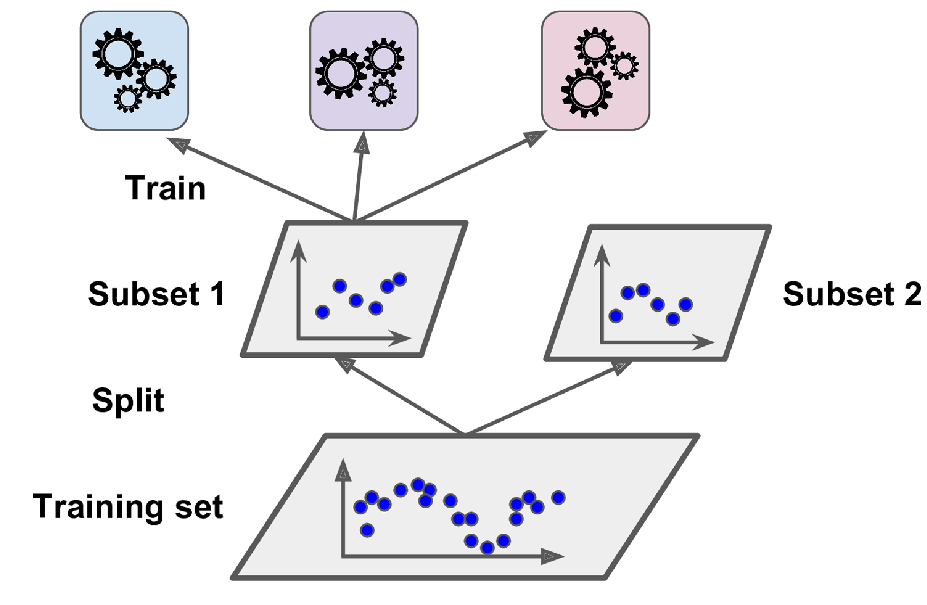

In [93]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict8.png'))
plt.grid(False)
plt.axis('off');

Next, the first layer predictors are used to make predictions on the second (held-out)
set. This ensures that the predictions are “clean,” since the predictors
never saw these instances during training. Now for each instance in the hold-out set
there are three predicted values. We can create a new training set using these predicted
values as input features (which makes this new training set three-dimensional),
and keeping the target values. The blender is trained on this new training set, so it
learns to predict the target value given the first layer’s predictions.

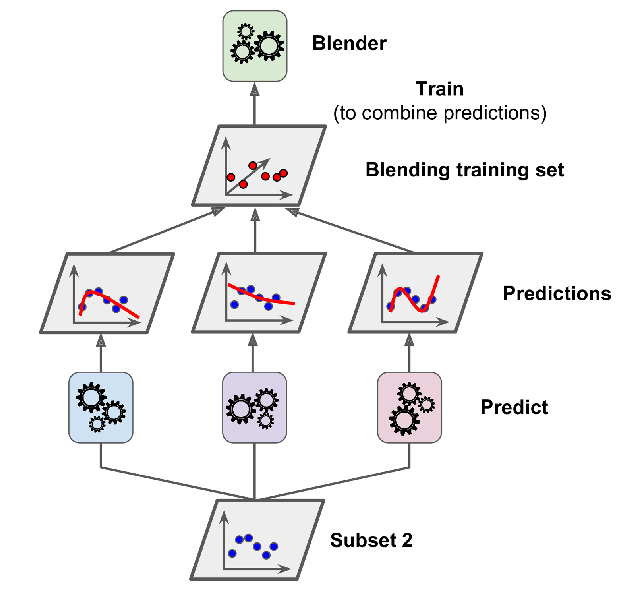

In [94]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict9.png'))
plt.grid(False)
plt.axis('off');

It is actually possible to train several different blenders this way (e.g., one using Linear
Regression, another using Random Forest Regression, and so on): we get a whole
layer of blenders. The trick is to split the training set into three subsets: the first one is
used to train the first layer, the second one is used to create the training set used to
train the second layer (using predictions made by the predictors of the first layer),
and the third one is used to create the training set to train the third layer (using predictions
made by the predictors of the second layer). Once this is done, we can make
a prediction for a new instance by going through each layer sequentially

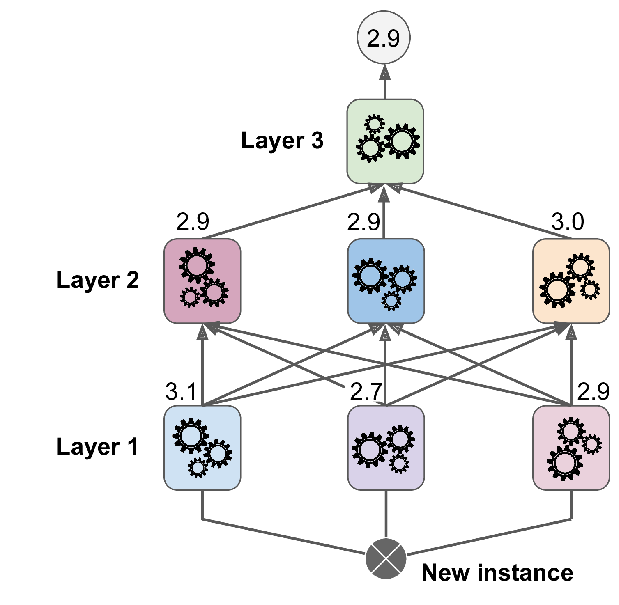

In [95]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(plt.imread('pict10.png'))
plt.grid(False)
plt.axis('off');